<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

mkdir: cannot create directory ‘/root/.kaggle’: File exists
User cancelled operation
mkdir: cannot create directory ‘Dataset’: File exists


Defining model arcitechture

In [127]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(64,128, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128,192, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(192,192,3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,128,3, stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.pool3 = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(16*2*2)
        self.bn2 = nn.BatchNorm2d(32*2*2)
        self.bn3 = nn.BatchNorm2d(192)
        self.bn4 = nn.BatchNorm2d(192)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm1d(150)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608,150)
        self.fc2 = nn.Linear(150,64)
        self.fc3 = nn.Linear(64,18)

    def forward(self, x):
        #print(x.size())
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #print(x.size())
        #x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        #print(x.size())
        #x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #print(x.size())
        x = F.relu(self.bn4(self.conv4(x)))
        #print(x.size())
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        #print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.size())
        #x = self.dropout3(x)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn7(self.fc2(x)))
        logits = self.fc3(x)
        return logits

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir,transform=None, target_transform=None,transform_aug = None,targets_available=True, use_captions=False):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.transform_aug = transform_aug
        self.target_transform = target_transform
        self.targets_available = targets_available
        self.use_captions = use_captions

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if self.use_captions:
           # Still in testing phase
           caption = self.img_labels.iloc[idx,2]
           print("Caption: {}".format(caption))
           #caption_embedded = text_to_embed(caption)
           print("Caption Embedding Shape:", caption.shape)

        image = pil_process_image_color(img_path)
        if self.targets_available:
          label = self.img_labels.iloc[idx, 1]
        else:
          label = []

        if self.target_transform and self.targets_available:
            label = self.target_transform(label)

        if self.transform_aug and label[0]!=1:
            image = self.transform_aug(image)
        else:
            image = self.transform(image)

        # if self.use_caption:
        #   return image, caption, label
        return image, label

Setup dataloaders and initialize model

In [128]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
from Dataload import pil_process_image_color, encode, Dataset #CustomImageDataset#, AddGaussianNoise
from utils import train_network, pos_weight, test
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(tensor + noise, 0, 1)  # Ensure pixel values remain valid

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Hyperparameters
batch_size = 64
lr = 0.001 # 0.0005 before
weight_decay = 0 #1e-4
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

Normalize_weights = True
Use_weighted_loss = False

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# Defining transforms
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # For resizing images to square

# Transform to use on common class
trainTransforms_basic = transforms.Compose(
    [resize,transforms.ToTensor()
    ,transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])
    #AddGaussianNoise(mean=0., std=0.1)])

# Data augmentation for uncommon class
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=30),
     transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])

# Transform for test images
testTransforms = transforms.Compose([resize,transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4652, 0.4492, 0.4214], std=[0.2317, 0.2265, 0.2303])])

# Sampling method
if Normalize_weights:
  # Calculate weights for loss function
  c_weights = pos_weight(df_train,barplot=False,normalize=True)
  samples_weight = torch.load("/content/norm_samples_weight_full.pt") # Sample common class less
else:
  c_weights = pos_weight(df_train,barplot=False,normalize=False)
  samples_weight = torch.load("/content/unnorm_samples_weight_full.pt") # Sample common class less

weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full) #Instead of shuffle = True
test_dataloader = DataLoader(test_data,shuffle=False)

# Setup model
model = CNN().to(device)

# Use BCE loss
if Use_weighted_loss:
  loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
else:
  loss = torch.nn.BCEWithLogitsLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print('Model initialized.')

We are using GPU.
Class counts: tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,  1020.],
       dtype=torch.float64)
Class weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646, 0.2461],
       dtype=torch.float64)
Model initialized.


Training on subset of all data and compute metrics for validation set

  0%|          | 0/15 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.660911

Train Epoch: 0 [3200/23996 (13%)]	Loss: 0.377469

Train Epoch: 0 [6400/23996 (27%)]	Loss: 0.307713

Train Epoch: 0 [9600/23996 (40%)]	Loss: 0.296308

Train Epoch: 0 [12800/23996 (53%)]	Loss: 0.314576

Train Epoch: 0 [16000/23996 (67%)]	Loss: 0.309429

Train Epoch: 0 [19200/23996 (80%)]	Loss: 0.280278

Train Epoch: 0 [22400/23996 (93%)]	Loss: 0.273221


  7%|▋         | 1/15 [01:41<23:44, 101.77s/it]


Test set results: Average loss: 0.1883, F1 Score: 0.66

Train Epoch: 1 [0/23996 (0%)]	Loss: 0.273869

Train Epoch: 1 [3200/23996 (13%)]	Loss: 0.249423

Train Epoch: 1 [6400/23996 (27%)]	Loss: 0.272153

Train Epoch: 1 [9600/23996 (40%)]	Loss: 0.290225

Train Epoch: 1 [12800/23996 (53%)]	Loss: 0.260781

Train Epoch: 1 [16000/23996 (67%)]	Loss: 0.267305

Train Epoch: 1 [19200/23996 (80%)]	Loss: 0.266053

Train Epoch: 1 [22400/23996 (93%)]	Loss: 0.270137


 13%|█▎        | 2/15 [03:22<21:55, 101.22s/it]


Test set results: Average loss: 0.1847, F1 Score: 0.65

Train Epoch: 2 [0/23996 (0%)]	Loss: 0.263159

Train Epoch: 2 [3200/23996 (13%)]	Loss: 0.251498

Train Epoch: 2 [6400/23996 (27%)]	Loss: 0.266624

Train Epoch: 2 [9600/23996 (40%)]	Loss: 0.254179

Train Epoch: 2 [12800/23996 (53%)]	Loss: 0.271211

Train Epoch: 2 [16000/23996 (67%)]	Loss: 0.241589

Train Epoch: 2 [19200/23996 (80%)]	Loss: 0.232061

Train Epoch: 2 [22400/23996 (93%)]	Loss: 0.262028


 20%|██        | 3/15 [05:04<20:20, 101.68s/it]


Test set results: Average loss: 0.1683, F1 Score: 0.67

Train Epoch: 3 [0/23996 (0%)]	Loss: 0.254588

Train Epoch: 3 [3200/23996 (13%)]	Loss: 0.236040

Train Epoch: 3 [6400/23996 (27%)]	Loss: 0.241161

Train Epoch: 3 [9600/23996 (40%)]	Loss: 0.247652

Train Epoch: 3 [12800/23996 (53%)]	Loss: 0.221949

Train Epoch: 3 [16000/23996 (67%)]	Loss: 0.246482

Train Epoch: 3 [19200/23996 (80%)]	Loss: 0.218788

Train Epoch: 3 [22400/23996 (93%)]	Loss: 0.222502


 27%|██▋       | 4/15 [06:46<18:38, 101.65s/it]


Test set results: Average loss: 0.1667, F1 Score: 0.66

Train Epoch: 4 [0/23996 (0%)]	Loss: 0.244232

Train Epoch: 4 [3200/23996 (13%)]	Loss: 0.225459

Train Epoch: 4 [6400/23996 (27%)]	Loss: 0.232557

Train Epoch: 4 [9600/23996 (40%)]	Loss: 0.230798

Train Epoch: 4 [12800/23996 (53%)]	Loss: 0.232472

Train Epoch: 4 [16000/23996 (67%)]	Loss: 0.238384

Train Epoch: 4 [19200/23996 (80%)]	Loss: 0.214066

Train Epoch: 4 [22400/23996 (93%)]	Loss: 0.201131


 33%|███▎      | 5/15 [08:28<16:57, 101.77s/it]


Test set results: Average loss: 0.1641, F1 Score: 0.67

Train Epoch: 5 [0/23996 (0%)]	Loss: 0.207616

Train Epoch: 5 [3200/23996 (13%)]	Loss: 0.247236

Train Epoch: 5 [6400/23996 (27%)]	Loss: 0.210831

Train Epoch: 5 [9600/23996 (40%)]	Loss: 0.220837

Train Epoch: 5 [12800/23996 (53%)]	Loss: 0.205001

Train Epoch: 5 [16000/23996 (67%)]	Loss: 0.220861

Train Epoch: 5 [19200/23996 (80%)]	Loss: 0.227077

Train Epoch: 5 [22400/23996 (93%)]	Loss: 0.242394


 40%|████      | 6/15 [10:10<15:17, 101.95s/it]


Test set results: Average loss: 0.1611, F1 Score: 0.68

Train Epoch: 6 [0/23996 (0%)]	Loss: 0.209317

Train Epoch: 6 [3200/23996 (13%)]	Loss: 0.225527

Train Epoch: 6 [6400/23996 (27%)]	Loss: 0.198736

Train Epoch: 6 [9600/23996 (40%)]	Loss: 0.192833

Train Epoch: 6 [12800/23996 (53%)]	Loss: 0.216264

Train Epoch: 6 [16000/23996 (67%)]	Loss: 0.207751

Train Epoch: 6 [19200/23996 (80%)]	Loss: 0.195510

Train Epoch: 6 [22400/23996 (93%)]	Loss: 0.246945


 47%|████▋     | 7/15 [11:51<13:33, 101.69s/it]


Test set results: Average loss: 0.1606, F1 Score: 0.69

Train Epoch: 7 [0/23996 (0%)]	Loss: 0.197042

Train Epoch: 7 [3200/23996 (13%)]	Loss: 0.218157

Train Epoch: 7 [6400/23996 (27%)]	Loss: 0.200362

Train Epoch: 7 [9600/23996 (40%)]	Loss: 0.192549

Train Epoch: 7 [12800/23996 (53%)]	Loss: 0.201102

Train Epoch: 7 [16000/23996 (67%)]	Loss: 0.209979

Train Epoch: 7 [19200/23996 (80%)]	Loss: 0.184630

Train Epoch: 7 [22400/23996 (93%)]	Loss: 0.170432


 53%|█████▎    | 8/15 [13:33<11:51, 101.69s/it]


Test set results: Average loss: 0.1653, F1 Score: 0.67

Train Epoch: 8 [0/23996 (0%)]	Loss: 0.203795

Train Epoch: 8 [3200/23996 (13%)]	Loss: 0.186575

Train Epoch: 8 [6400/23996 (27%)]	Loss: 0.204149

Train Epoch: 8 [9600/23996 (40%)]	Loss: 0.179151

Train Epoch: 8 [12800/23996 (53%)]	Loss: 0.192933

Train Epoch: 8 [16000/23996 (67%)]	Loss: 0.189825

Train Epoch: 8 [19200/23996 (80%)]	Loss: 0.185319

Train Epoch: 8 [22400/23996 (93%)]	Loss: 0.170905


 60%|██████    | 9/15 [15:15<10:10, 101.81s/it]


Test set results: Average loss: 0.1613, F1 Score: 0.67

Train Epoch: 9 [0/23996 (0%)]	Loss: 0.157802

Train Epoch: 9 [3200/23996 (13%)]	Loss: 0.192057

Train Epoch: 9 [6400/23996 (27%)]	Loss: 0.169839

Train Epoch: 9 [9600/23996 (40%)]	Loss: 0.184087

Train Epoch: 9 [12800/23996 (53%)]	Loss: 0.165945

Train Epoch: 9 [16000/23996 (67%)]	Loss: 0.177705

Train Epoch: 9 [19200/23996 (80%)]	Loss: 0.165229

Train Epoch: 9 [22400/23996 (93%)]	Loss: 0.149601


 67%|██████▋   | 10/15 [16:57<08:28, 101.69s/it]


Test set results: Average loss: 0.1612, F1 Score: 0.67

Train Epoch: 10 [0/23996 (0%)]	Loss: 0.180019

Train Epoch: 10 [3200/23996 (13%)]	Loss: 0.169307

Train Epoch: 10 [6400/23996 (27%)]	Loss: 0.179087

Train Epoch: 10 [9600/23996 (40%)]	Loss: 0.166109

Train Epoch: 10 [12800/23996 (53%)]	Loss: 0.155392

Train Epoch: 10 [16000/23996 (67%)]	Loss: 0.153751

Train Epoch: 10 [19200/23996 (80%)]	Loss: 0.165512

Train Epoch: 10 [22400/23996 (93%)]	Loss: 0.170721


 73%|███████▎  | 11/15 [18:39<06:47, 101.87s/it]


Test set results: Average loss: 0.1693, F1 Score: 0.66

Train Epoch: 11 [0/23996 (0%)]	Loss: 0.184916

Train Epoch: 11 [3200/23996 (13%)]	Loss: 0.151691

Train Epoch: 11 [6400/23996 (27%)]	Loss: 0.161465

Train Epoch: 11 [9600/23996 (40%)]	Loss: 0.160414

Train Epoch: 11 [12800/23996 (53%)]	Loss: 0.130458

Train Epoch: 11 [16000/23996 (67%)]	Loss: 0.157065

Train Epoch: 11 [19200/23996 (80%)]	Loss: 0.155928

Train Epoch: 11 [22400/23996 (93%)]	Loss: 0.157417


 80%|████████  | 12/15 [20:20<05:05, 101.79s/it]


Test set results: Average loss: 0.1717, F1 Score: 0.65

Train Epoch: 12 [0/23996 (0%)]	Loss: 0.139043

Train Epoch: 12 [3200/23996 (13%)]	Loss: 0.145231

Train Epoch: 12 [6400/23996 (27%)]	Loss: 0.173057

Train Epoch: 12 [9600/23996 (40%)]	Loss: 0.153240

Train Epoch: 12 [12800/23996 (53%)]	Loss: 0.135735

Train Epoch: 12 [16000/23996 (67%)]	Loss: 0.162470

Train Epoch: 12 [19200/23996 (80%)]	Loss: 0.159370

Train Epoch: 12 [22400/23996 (93%)]	Loss: 0.148273


 87%|████████▋ | 13/15 [22:02<03:23, 101.69s/it]


Test set results: Average loss: 0.1639, F1 Score: 0.66

Train Epoch: 13 [0/23996 (0%)]	Loss: 0.134450

Train Epoch: 13 [3200/23996 (13%)]	Loss: 0.170966

Train Epoch: 13 [6400/23996 (27%)]	Loss: 0.153620

Train Epoch: 13 [9600/23996 (40%)]	Loss: 0.152686

Train Epoch: 13 [12800/23996 (53%)]	Loss: 0.138683

Train Epoch: 13 [16000/23996 (67%)]	Loss: 0.136845

Train Epoch: 13 [19200/23996 (80%)]	Loss: 0.141121

Train Epoch: 13 [22400/23996 (93%)]	Loss: 0.138879


 93%|█████████▎| 14/15 [23:44<01:41, 101.80s/it]


Test set results: Average loss: 0.1719, F1 Score: 0.66

Train Epoch: 14 [0/23996 (0%)]	Loss: 0.124278

Train Epoch: 14 [3200/23996 (13%)]	Loss: 0.123639

Train Epoch: 14 [6400/23996 (27%)]	Loss: 0.147300

Train Epoch: 14 [9600/23996 (40%)]	Loss: 0.139203

Train Epoch: 14 [12800/23996 (53%)]	Loss: 0.130416

Train Epoch: 14 [16000/23996 (67%)]	Loss: 0.134795

Train Epoch: 14 [19200/23996 (80%)]	Loss: 0.134895

Train Epoch: 14 [22400/23996 (93%)]	Loss: 0.133632


100%|██████████| 15/15 [25:25<00:00, 101.69s/it]


Test set results: Average loss: 0.1692, F1 Score: 0.66


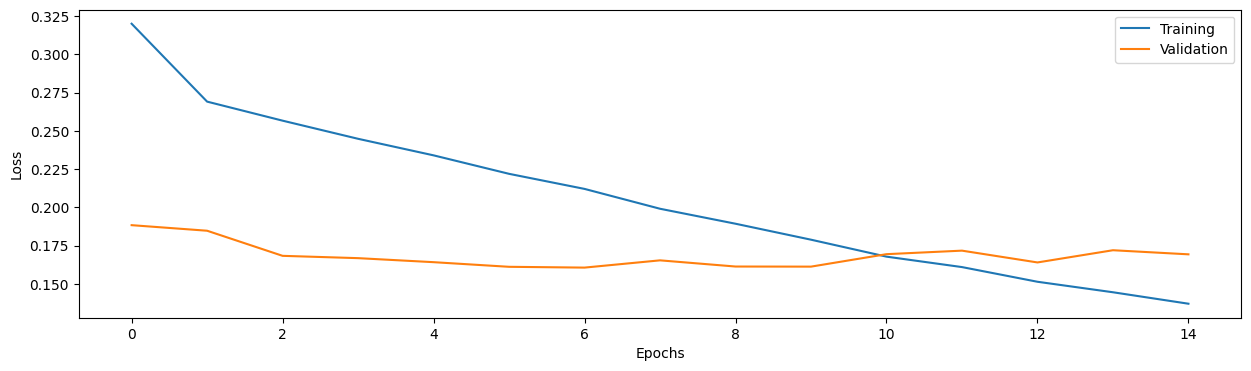

With prediction_all = True:

Test set results: Average loss: 0.1680, F1 Score: 0.66
Full Metrics
{'F1_score': 0.6587441963298696, 'accuracy': 0.9428333333333333, 'precision': 0.6721182043762689, 'recall': 0.6458920442228485}


In [129]:
# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")

# Loading sample weights to sample some classes more than others

if Normalize_weights:
  samples_weight_subset = torch.load("/content/norm_samples_weight_subset.pt")
else:
  samples_weight_subset = torch.load("/content/unnorm_samples_weight_subset.pt") # Sample common class less

weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset) #shuffle=True)
validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 50 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=15)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Set thresholds for predictions
thresholds = [0.5]*18

# Testing on validation set and compute metrics
print("With prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=True) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

# print("With prediction_all = False:")
# test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
# all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
# all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
# print("Full Metrics")
# print(compute_metrics(all_preds,all_targets))

In [70]:
print("Prediction on training set with prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, subset_train_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))

Prediction on training set with prediction_all = True:

Test set results: Average loss: 0.0925, F1 Score: 0.87


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (375,) + inhomogeneous part.

Tuning of thresholds

In [ ]:
threshold_values = [0.55,0.5,0.45,0.4,0.35,0.3]
thresholds = [0.5]*18
best_thresholds = []
for label in range(1,19): # remember that class 12 is deleted!
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in tqdm(range(len(threshold_values))):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Check model size and save temporary model

Model saved to /content/model_test.pt
Model size: 6.491914749145508 MB


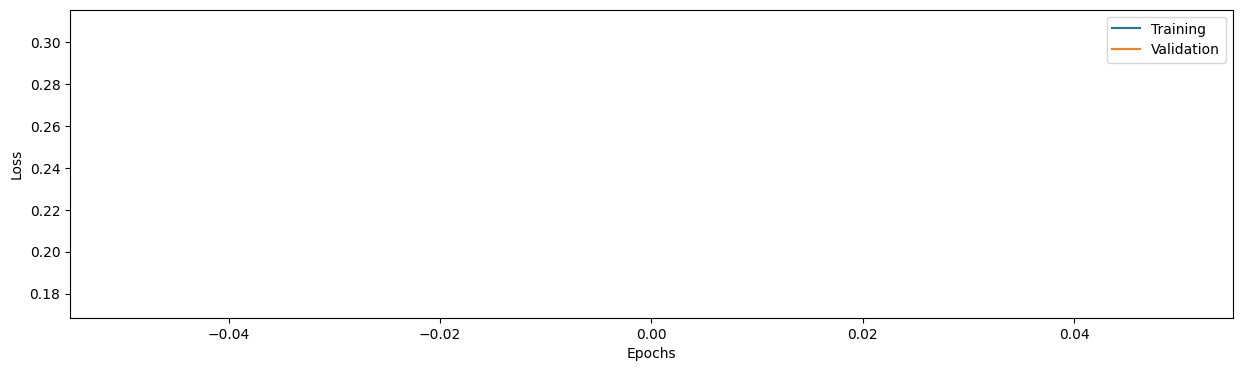

In [120]:
# save model, scores and plot and check size of model is under 100MB
model_name = "test"

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(compute_metrics(all_preds,all_targets)))

Train model on entire training set and compute predictions

In [ ]:
# Training new model on the full dataset
model_full = CNN().to(device)
c_weights_full = c_weights.to(device)
loss_full = torch.nn.BCEWithLogitsLoss() #c_weights_full)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Full Model initialized.')
log_interval = 50 # How often we print train loss
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss_full,epochs=30)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

Full Model initialized.


  0%|          | 0/30 [00:00<?, ?it/s]


Train Epoch: 0 [0/29996 (0%)]	Loss: 0.761133

Train Epoch: 0 [12800/29996 (53%)]	Loss: 0.314905


  3%|▎         | 1/30 [01:20<38:57, 80.61s/it]


Train Epoch: 1 [0/29996 (0%)]	Loss: 0.197992


  3%|▎         | 1/30 [01:51<53:48, 111.33s/it]


KeyboardInterrupt: 

In [ ]:
# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

100%|██████████| 10000/10000 [00:45<00:00, 221.22it/s]



Predictions computed for test set.


100%|██████████| 10000/10000 [00:45<00:00, 221.08it/s]


Predictions computed for test set.


Save full model, check size and get predictions

Full Model saved to /content/model_24_05_25_two_hidden_full.pt
Full Model size: 3.243013381958008 MB
Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg  1 3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
Predictions saved as /content/submission_pred_all_false.csv


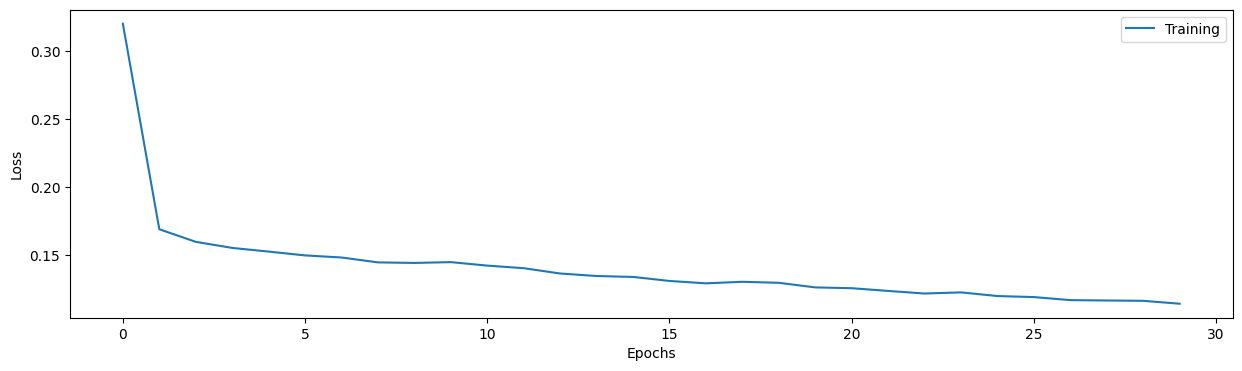

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

#test_pred_full = test(model_full, device, test_dataloader,loss,thresholds=thresholds_full,target_available=False)
#print(test_pred_full)

def get_class(array):
  class_pred = np.where(array > 0.5)[1] + 1
  for i in range(len(class_pred)):
    if class_pred[i] >= 12:
      class_pred += 1
  return class_pred

def unencode(y_pred,to_cpu=True):
  labels = []
  for i in range(len(y_pred)):
    if to_cpu: # Move to cpu device
      temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

# Save full model
path_name_model = "/content/model_" + model_name + "_full.pt"
path_name_plot = "/content/model_" + model_name + "_losscurve_full.png"

torch.save(model_full.state_dict(), path_name_model)
print(f"Full Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Full Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

#Save predictions in csv
pred_labels = unencode(test_pred_full_predict_all_false)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "More complex CNN without pred all"

100% 120k/120k [00:00<00:00, 125kB/s]
Successfully submitted to Multi-label Classification Competition 2025